In [6]:
from keras.datasets import mnist
import numpy as np
import keras
from keras import layers
from sklearn.model_selection import train_test_split 


(x_train, y_train), (x_test, y_test) = mnist.load_data()


def prepare_datasets(validation_size, x_test, y_test):
    x_train, x_validation, y_train, y_validation = train_test_split(x_test, y_test, test_size=validation_size)
    return x_test, x_validation, y_test, y_validation

x_test, x_validation, y_test, y_validation = prepare_datasets( 0.2,x_test, y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_validation = x_validation.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_validation = x_validation.reshape((len(x_validation), np.prod(x_validation.shape[1:])))

original_dim = 28 * 28
intermediate_dim = 400
latent_dim = 20

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')



reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.fit(x_train, x_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_validation, x_validation))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 145.7271 - val_loss: 87.3586
Epoch 2/20
1875/1875 [==============================] - 5s 2ms/step - loss: 86.9480 - val_loss: 80.6385
Epoch 3/20
1875/1875 [==============================] - 5s 2ms/step - loss: 81.3979 - val_loss: 77.7727
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 78.9242 - val_loss: 76.3349
Epoch 5/20
1875/1875 [==============================] - 5s 2ms/step - loss: 77.3207 - val_loss: 75.6436
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 76.4548 - val_loss: 74.9717
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 75.6863 - val_loss: 74.5053
Epoch 8/20
1875/1875 [==============================] - 5s 2ms/step - loss: 75.3679 - val_loss: 74.2047
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 74.8312 - val_loss: 73.9776
Epoch 10/20
1875/1875 [==============================] - 5s 2ms

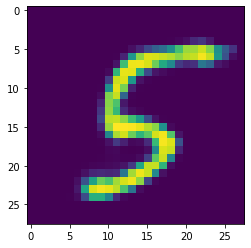

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
Indices_of_5 = np.where(y_test == 5)
img1 = x_test[Indices_of_5[0][2]].reshape(1,-1)
img2 = x_test[Indices_of_5[0][4]].reshape(1,-1)
z0 = encoder(img1)[2]
z1 = encoder(img2)[2]
z = (7/8 * z0 + (1 - 7/8) * z1)
output = decoder.predict(z)
output = tf.reshape(output , [28,28])
some_digit_show = plt.imshow(output)
plt.savefig('some_digit.png')

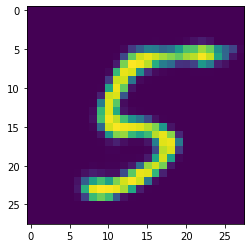

In [8]:

# get 7 linear interpolates  for all digits (0 to 9)
def get_interpolation():
  total_digits = []
  total_test_orginal = []
  w = np.linspace(start = 1/8, stop = 7/8, num=7) #7 different values of lambda between 0 and 1
  for j in range(10): 
    output_of_digits = []
    Indices = np.where(y_test == j) #to get labels of same digit
    img1 = x_test[Indices[0][2]].reshape(1,-1)
    img2 = x_test[Indices[0][4]].reshape(1,-1)
    z0 = encoder(img1)[2]
    z1 = encoder(img2)[2]
    total_test_orginal.append([img1,img2]) #store the original test two digits
    for i in w:
      z = (i * z0 + (1 - i) * z1)
      output = decoder(z)
      output = tf.reshape(output , [28,28])
      output_of_digits.append(output)
    total_digits.append(output_of_digits) #store result of interpolation between two same digit
  return total_digits, total_test_orginal

total_interpolation, total_test = get_interpolation()
some_digit_show = plt.imshow(tf.reshape(total_interpolation[5][6] , [28,28]))



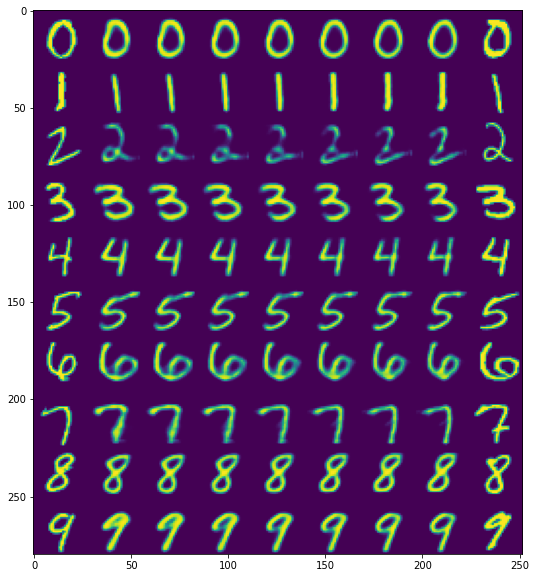

In [9]:
digit_size = 28
figure = np.zeros((digit_size * 10, digit_size * 9)) # figure with 10x9 size

for i in range(10):
  for j in np.linspace(start = 0, stop = 8, num=2):
      figure[i * digit_size: (i + 1) * digit_size,
            int(j) * digit_size: (int(j) + 1) * digit_size] = total_test[i][(int(j)//8)].reshape(28,28)
for i in range(10):
  for j in np.linspace(start = 1, stop = 7, num=7):
      figure[i * digit_size: (i + 1) * digit_size,
           int(j) * digit_size: (int(j) + 1) * digit_size] = tf.reshape(total_interpolation[i][int(j)-1] , [28,28])


plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('outvae.png')
plt.show()


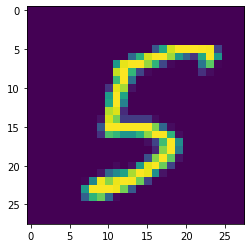

In [33]:
# point(f) 7 linear interpolates between two different random digits
import random

def get_interpolation_random():
  total_digits = []
  total_test_orginal = []
  w = np.linspace(start = 1/8, stop = 7/8, num=7) #7 different values of lambda between 0 and 1
  for j in random.sample(range(1, 100), 10):
    output_of_digits = []
    img1 = x_test[j].reshape(1,-1)
    img2 = x_test[j+1].reshape(1,-1)
    z0 = encoder(img1)[2]
    z1 = encoder(img2)[2]
    total_test_orginal.append([img1,img2]) #store the original test two different random digits
    for i in w:
      z = ((1 - i) * z0 + i * z1)
      output = decoder(z)
      output = tf.reshape(output , [28,28])
      output_of_digits.append(output)
    total_digits.append(output_of_digits) #store result of interpolation between two different  random digits
  return total_digits, total_test_orginal

total_interpolate_different, total_different = get_interpolation_random()
some_digit_show = plt.imshow(tf.reshape(total_different[1][1] , [28,28]))

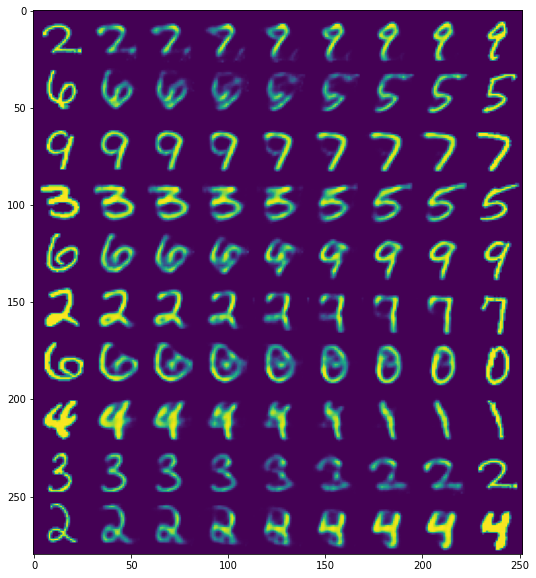

In [35]:
digit_size = 28
figure = np.zeros((digit_size * 10, digit_size * 9)) # figure with 10x9 size

for i in range(10):
  for j in np.linspace(start = 0, stop = 8, num=2):
      figure[i * digit_size: (i + 1) * digit_size,
            int(j) * digit_size: (int(j) + 1) * digit_size] = total_different[i][(int(j)//8)].reshape(28,28)
for i in range(10):
  for j in np.linspace(start = 1, stop = 7, num=7):
      figure[i * digit_size: (i + 1) * digit_size,
           int(j) * digit_size: (int(j) + 1) * digit_size] = tf.reshape(total_interpolate_different[i][int(j)-1] , [28,28])


plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('outvae2.png')
plt.show()